In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import anndata

import seaborn as sns 
import pandas as pd

import scanpy as sc
from readcount_tools import compute_gene_stats, compute_kde

from readcount_tools import plot_mean_vs
#import plotting constants
from readcount_tools import PAPER_CONTEXT, PAGEWIDTH_IN, SMALL_SIZE,MEDIUM_SIZE,BIGGER_SIZE,LINEWIDTH,POINTSIZE,TICKLENGTH,LEGEND_FONTSIZE,SPINEWIDTH,LETTER_LOC_X,LETTER_LOC_Y

In [2]:
basepath = 'data/tasic/'
kde=True #set to False for faster plotting without density maps

In [3]:
adata_single_cluster = anndata.read_h5ad(f'{basepath}adata_single_cluster.h5ad')
print(adata_single_cluster.uns['clustername'],adata_single_cluster.shape)

L6 IT VISp Penk Col27a1 (1049, 33914)


/usr/local/lib/python3.8/dist-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/usr/local/lib/python3.8/dist-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [4]:
def compound_meanvar(means,alpha=100,theta=100):
    
    mean_range = np.logspace(np.log10(min(means)),np.log10(max(means)),num=100)
    var_predicted = mean_range * alpha + mean_range**2 / theta
    return mean_range,var_predicted

def compound_meanFF(means,alpha=100,theta=100):
    
    mean_range = np.logspace(np.log10(min(means)),np.log10(max(means)),num=100)
    var_predicted = mean_range * alpha + mean_range**2 / theta
    ff_predicted = var_predicted / mean_range
    return mean_range,ff_predicted

def compound_meanzero(means,theta=np.Inf,mean_z=10):
    
    mean_range_molecules = np.logspace(np.log10(min(means/mean_z)),np.log10(max(means/mean_z)),num=100)
    if np.isinf(theta):
        fraction_zeros_predicted = np.exp(-mean_range_molecules)
    else:
        fraction_zeros_predicted = (theta / (mean_range_molecules+theta))**(theta)
    
    mean_range_readcounts = mean_range_molecules * mean_z
    
    return mean_range_readcounts,fraction_zeros_predicted

In [5]:
def plot_compound_var(ad,ax,alphas,thetas,colors=None,show_theta=False,xkey='gene_mean_withinCluster',plot_kwargs={}):

    for alpha,theta,color in zip(alphas,thetas,colors):
        mean_compound,var_compound = compound_meanvar(ad.var[xkey],alpha=alpha,theta=theta)

        if show_theta:
            legend_label = fr'{theta}'
        else:
            legend_label =fr'{alpha}'
        ax.plot(mean_compound,var_compound,label=legend_label,linestyle='--',color=color,**plot_kwargs)

def plot_compound_ff(ad,ax,alphas,thetas,colors=None,show_theta=False,xkey='gene_mean_withinCluster',plot_kwargs={}):

    for alpha,theta,color in zip(alphas,thetas,colors):
        mean_compound,var_compound = compound_meanFF(ad.var[xkey],alpha=alpha,theta=theta)

        if show_theta:
            legend_label = fr'{theta}'
        else:
            legend_label =fr'{alpha}'
        ax.plot(mean_compound,var_compound,label=legend_label,linestyle='--',color=color,**plot_kwargs)

def plot_compound_zeros(ad,ax,alphas,thetas,means,colors,show_theta=False,xkey='gene_mean_withinCluster',plot_kwargs={}):
    
    for alpha,theta,mean,color in zip(alphas,thetas,means,colors):
            
        mean_compound,zeros_compound = compound_meanzero(ad.var[xkey],mean_z=mean,theta=theta)

        if show_theta:
            legend_label = fr'{theta}'
        else:
            alpha_str=str(alpha)
            alpha_str=f'{alpha_str}, {(3-len(alpha_str))*"  "}'
            legend_label = f'{alpha_str}{mean}'.expandtabs()

        ax.plot(mean_compound,zeros_compound,label=legend_label,linestyle='--',color=color,**plot_kwargs)

### Figure 2 - homogeneous data

tcmalloc: large alloc 9201278976 bytes == 0xd410000 @ 
tcmalloc: large alloc 9201278976 bytes == 0x235998000 @ 
tcmalloc: large alloc 9201278976 bytes == 0x45a89e000 @ 
tcmalloc: large alloc 9201278976 bytes == 0x67f7a4000 @ 
tcmalloc: large alloc 9201278976 bytes == 0x8a46aa000 @ 
tcmalloc: large alloc 9201278976 bytes == 0x235998000 @ 
tcmalloc: large alloc 9201278976 bytes == 0x45a89e000 @ 
tcmalloc: large alloc 9201278976 bytes == 0x67f7a4000 @ 
tcmalloc: large alloc 9201278976 bytes == 0x8a46aa000 @ 
tcmalloc: large alloc 9201278976 bytes == 0xd410000 @ 
tcmalloc: large alloc 9201278976 bytes == 0x235998000 @ 
tcmalloc: large alloc 9201278976 bytes == 0x45a89e000 @ 
tcmalloc: large alloc 9201278976 bytes == 0x67f7a4000 @ 
tcmalloc: large alloc 9201278976 bytes == 0x8a46aa000 @ 
tcmalloc: large alloc 9201278976 bytes == 0xd410000 @ 


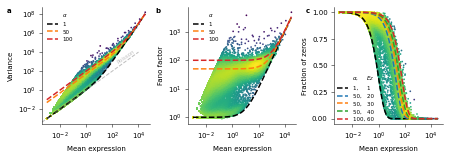

In [6]:
ncols = 3
figheight_in = PAGEWIDTH_IN/ncols

def finalize_fig2(axes,letters=['a','b','c'],x_corrections=[-0.02,0,0.04]):
    for ax,letter,letter_x_correction in zip(axes,letters,x_corrections):
        for axis in ['bottom','left']:
            ax.spines[axis].set_linewidth(SPINEWIDTH)
        ax.text(LETTER_LOC_X+letter_x_correction,LETTER_LOC_Y,letter,transform=ax.transAxes,fontweight='bold')
        ax.minorticks_off()
        ax.set_xlabel('Mean expression')
        ax.set_xticks([1e-02, 1e+00, 1e+02, 1e+04])


    
def fig2_scatter(ad,axes,kde=False,colorby='',vmin=None,vmax=None):

    ax1,ax2,ax3 = axes.flatten()
    
    plot_mean_vs(ad,np.array(ax1),xkey='gene_mean_withinCluster',ykey='gene_var_withinCluster',
                 kde=kde,autotitle=False,colorby=colorby,vmin=vmin,vmax=vmax)
    ax1.set_yticks([1e-02, 1e+00, 1e+02, 1e+04, 1e+06, 1e+08])
    ax1.set_ylabel('Variance')

    plot_mean_vs(ad,np.array(ax2),xkey='gene_mean_withinCluster',ykey='gene_FF_withinCluster',
                 kde=kde,autotitle=False,colorby=colorby,vmin=vmin,vmax=vmax)
    ax2.set_ylabel('Fano factor')
        
    plot_mean_vs(ad,np.array(ax3),xkey='gene_mean_withinCluster',ykey='gene_fraction_zeros_withinCluster',yscale='linear',
                 kde=kde,autotitle=False,colorby=colorby,vmin=vmin,vmax=vmax)
    ax3.set_yticks([0,0.5,1])
    ax3.set_ylabel('Fraction of zeros')
    ax3.set_yscale('linear')

    sns.despine()
    plt.tight_layout()

    finalize_fig2(axes.flatten())
        
        
def fig2_lines(ad,axes,kde=False):
    
    ax1,ax2,ax3 = axes.flatten()

    plot_compound_var(ad,ax1,alphas=[1,50,100],thetas=[10,10,10],colors=['k','tab:orange','tab:red'])
    ax1.legend(loc='upper left',fontsize=LEGEND_FONTSIZE,title=r'      $\alpha$',title_fontsize=LEGEND_FONTSIZE,frameon=False)
    
    plot_compound_ff(ad,ax2,alphas=[1,50,100],thetas=[10,10,10],colors=['k','tab:orange','tab:red'])
    ax2.legend(loc='upper left',fontsize=LEGEND_FONTSIZE,title=r'      $\alpha$',title_fontsize=LEGEND_FONTSIZE,frameon=False)
    
    plot_compound_zeros(ad,ax3,thetas=[10,10,10,10,10],means=[1,20,30,40,60], alphas=[1,50,50,50,100],
    colors=['k','tab:blue','tab:orange','tab:green','tab:red'])
    leg3 = ax3.legend(loc=(0.01,0),fontsize=LEGEND_FONTSIZE,title=r'$\alpha$,     $E_Z$',title_fontsize=LEGEND_FONTSIZE,frameon=False)
    leg3._legend_box.align = "right"

with mpl.rc_context(PAPER_CONTEXT):
    fig,axes=plt.subplots(1,3,figsize=(PAGEWIDTH_IN,figheight_in),squeeze=False,sharex=True)
    fig2_scatter(adata_single_cluster,axes,kde=kde)
    fig2_lines(adata_single_cluster,axes)
    
    axes[0][0].plot([10*-2,10**4],[10*-2,10**4],c='tab:gray',linestyle='--',linewidth=LINEWIDTH,alpha=0.5)
    axes[0][0].text(10**2.3,10**2.3*3,'Poisson',c='tab:gray',rotation=35,fontsize=LEGEND_FONTSIZE,alpha=0.5)
    
    plt.savefig('figures/main_tasic_homo.pdf', dpi=300, format=None, bbox_inches = 'tight', pad_inches = 0)


### Suppl. Figure 1 - effect of sequencing depth on overdispersion

Text(0.5, 1.0, 'within cluster depth distribution')

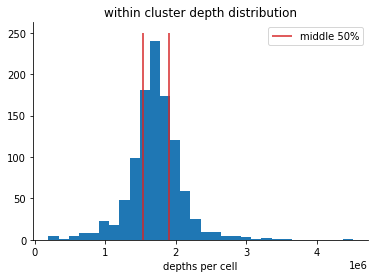

In [7]:
depths_fig1 = np.sum(adata_single_cluster.X,axis=1)
plt.hist(depths_fig1,bins=30)
depths_p1 = np.percentile(depths_fig1,1)
depths_p99 = np.percentile(depths_fig1,99)
depths_p25 = np.percentile(depths_fig1,25)
depths_p75 = np.percentile(depths_fig1,75)
plt.vlines([depths_p25,depths_p75],0,250,colors='tab:red',label='middle 50%')
plt.legend()
plt.xlabel('depths per cell')
sns.despine()
plt.title('within cluster depth distribution')

In [8]:
print('Before filtering 1st percentile',int(depths_p1))
print('Before filtering 99th percentile',int(depths_p99))

Before filtering 1st percentile 679033
Before filtering 99th percentile 2841189


In [9]:
middle50_idx = ((depths_fig1 > depths_p25 ) & (depths_fig1<depths_p75)).A.squeeze()
adata_single_cluster_middle50 = adata_single_cluster[middle50_idx,:]
sc.pp.filter_genes(adata_single_cluster_middle50,min_counts=1)
adata_single_cluster_middle50.shape

/gpfs01/berens/user/jlause/.local/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:249: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_counts'] = number
/usr/local/lib/python3.8/dist-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr/local/lib/python3.8/dist-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


(523, 31476)

In [10]:
depths_middle50 = adata_single_cluster_middle50.X.sum(axis=1).A

In [11]:
print('25st percentile',int(depths_p25))
print('75th percentile',int(depths_p75))

25st percentile 1535508
75th percentile 1903647


In [12]:
compute_gene_stats(adata_single_cluster_middle50,suffix='_withinCluster')
compute_gene_stats(adata_single_cluster,suffix='_withinCluster')

tcmalloc: large alloc 9201278976 bytes == 0x45a89e000 @ 
tcmalloc: large alloc 9201278976 bytes == 0x67f7a4000 @ 
tcmalloc: large alloc 9201278976 bytes == 0x8a46aa000 @ 
tcmalloc: large alloc 9201278976 bytes == 0xd2c4000 @ 
tcmalloc: large alloc 9201278976 bytes == 0xac95b0000 @ 
tcmalloc: large alloc 9201278976 bytes == 0xd2c4000 @ 
tcmalloc: large alloc 9201278976 bytes == 0x45a89e000 @ 
tcmalloc: large alloc 9201278976 bytes == 0x67f7a4000 @ 
tcmalloc: large alloc 9201278976 bytes == 0x8a46aa000 @ 
tcmalloc: large alloc 9201278976 bytes == 0xac95b0000 @ 
tcmalloc: large alloc 9201278976 bytes == 0xd2c4000 @ 
tcmalloc: large alloc 9201278976 bytes == 0x45a89e000 @ 
tcmalloc: large alloc 9201278976 bytes == 0x67f7a4000 @ 
tcmalloc: large alloc 9201278976 bytes == 0x8a46aa000 @ 
tcmalloc: large alloc 9201278976 bytes == 0xac95b0000 @ 


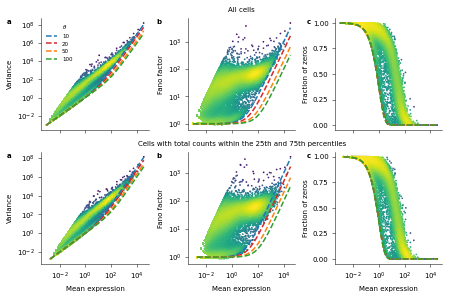

In [13]:
def fig2_theta_lines(ad,axes,alphas=[1,1,1,1],thetas=[10,20,50,100],colors=['tab:blue','tab:red','tab:orange','tab:green'],legend=True):
    
    ax1,ax2,ax3 = axes.flatten()

    plot_compound_var(ad,ax1,alphas=alphas,thetas=thetas, colors=colors,show_theta=True)
    if legend:
        ax1.legend(loc='upper left',fontsize=LEGEND_FONTSIZE,title=r'      $\theta$',title_fontsize=LEGEND_FONTSIZE,frameon=False)
    
    plot_compound_ff(ad,ax2,alphas=alphas,thetas=thetas, colors=colors,show_theta=True)
    
    plot_compound_zeros(ad,ax3,alphas=alphas,means=alphas, thetas=thetas, colors=colors,show_theta=True)

with mpl.rc_context(PAPER_CONTEXT):
    fig,axes=plt.subplots(2,3,figsize=(PAGEWIDTH_IN,figheight_in*2),squeeze=False,sharex=True)
    axes_row0 = axes[0,:]
    axes_row1 = axes[1,:]

    fig2_scatter(adata_single_cluster,axes_row0,kde=kde)
    fig2_theta_lines(adata_single_cluster,axes_row0)
    axes_row0[1].set_title('All cells')
    
    fig2_scatter(adata_single_cluster_middle50,axes_row1,kde=kde)
    fig2_theta_lines(adata_single_cluster_middle50,axes_row1,legend=False)
    axes_row1[1].set_title('Cells with total counts within the 25th and 75th percentiles')
    [ax.set_xlabel('') for ax in axes_row0]
    
    plt.tight_layout()
    
    plt.savefig('figures/S_tasic_homo_theta.pdf', dpi=300, format=None, bbox_inches = 'tight', pad_inches = 0)

### Suppl. Figure 2 - pseudogenes vs protein-coding genes

In [14]:
protein_coding_idx = adata_single_cluster.var['coarse_types'] == 'protein_coding'
pseudogenes_idx = adata_single_cluster.var['coarse_types'] == 'pseudogene'
missing_idx = adata_single_cluster.var['coarse_types'] == 'missing'
other_idx = adata_single_cluster.var['coarse_types'] == 'other'

In [15]:
labels,counts = np.unique(adata_single_cluster[:,other_idx].var['type_of_gene'],return_counts=True)
sort_idx = np.argsort(-counts)
other_types_str = ', '.join([f'{l}: {c}' for l,c in zip(labels[sort_idx],counts[sort_idx])])

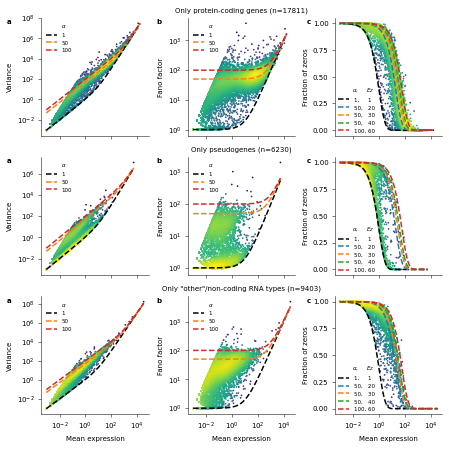

In [16]:
with mpl.rc_context(PAPER_CONTEXT):
    fig,axes=plt.subplots(3,3,figsize=(PAGEWIDTH_IN,figheight_in*3),squeeze=False,sharex=True)
    axes_row0 = axes[0,:]
    axes_row1 = axes[1,:]
    axes_row2 = axes[2,:]

    fig2_scatter(adata_single_cluster[:,protein_coding_idx],axes_row0,kde=kde)
    fig2_lines(adata_single_cluster[:,protein_coding_idx],axes_row0)
    axes_row0[1].set_title(f'Only protein-coding genes (n={sum(protein_coding_idx)})')
    [ax.set_xlabel('') for ax in axes_row0]
    
    fig2_scatter(adata_single_cluster[:,pseudogenes_idx],axes_row1,kde=kde)
    fig2_lines(adata_single_cluster[:,pseudogenes_idx],axes_row1)
    axes_row1[1].set_title(f'Only pseudogenes (n={sum(pseudogenes_idx)})')
    [ax.set_xlabel('') for ax in axes_row1]
    
    fig2_scatter(adata_single_cluster[:,other_idx],axes_row2,kde=kde)
    fig2_lines(adata_single_cluster[:,other_idx],axes_row2)
    axes_row2[1].set_title(f'Only "other"/non-coding RNA types (n={sum(other_idx)})')

    plt.tight_layout()
    
    plt.savefig('figures/S_tasic_homo_pseudogenes.pdf', dpi=300, format=None, bbox_inches = 'tight', pad_inches = 0)

### Suppl. Figure 4 - transcript length

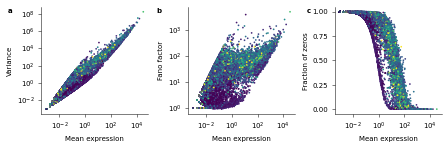

In [17]:
vmax = np.nanpercentile(adata_single_cluster.var['transcript_len_max'],98)
with mpl.rc_context(PAPER_CONTEXT):
    fig,axes=plt.subplots(1,3,figsize=(PAGEWIDTH_IN,figheight_in),squeeze=False,sharex=True)
    fig2_scatter(adata_single_cluster,axes,colorby='transcript_len_max',vmax=vmax)
    plt.tight_layout()
    plt.savefig('figures/S_tasic_homo_genelength.pdf', dpi=300, format=None, bbox_inches = 'tight', pad_inches = 0)

In [18]:
#number of genes not shown in the transcript length plot because of missing length annotaion
sum(np.isnan(adata_single_cluster.var.transcript_len_max))

11069

In [19]:
#length clipping threshold for colormap (98th percentile)
vmax

9851.599999999995